In [4]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

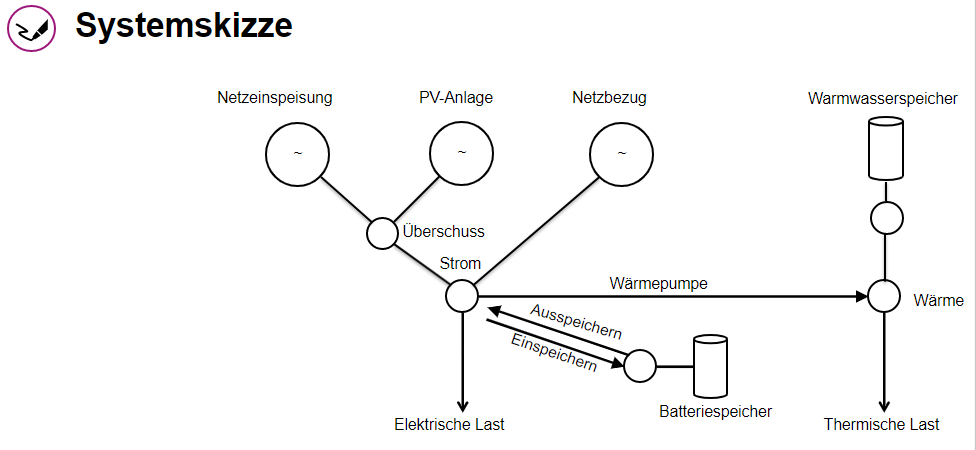

In [ ]:
# Systemskizze für das Referenzmodell -> Bestimmen welcher Autarkiegrad möglich ist und schauen zu welchen Konditionen überhaupt
# Auch hier können bereits Parameter verändert werden
# Sensivitätsanalyse/ Strompreis abhängigkeit/ größe des Speichers im Verhältnis zum Investiotionslimit etc.pp

In [5]:
#csv-Datei importieren
csv_datei = "Modellierung_SoSe23.csv"
df_data = pd.read_csv(csv_datei, sep=';', decimal = ',')
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34
...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12


In [6]:
# Bezeichnung der einzelnen Spalten

elektrische_last = df_data['Verbrauch ']
pv_ertrag        = df_data['PV-Ertrag']
thermische_last  = df_data['Thermische Last ']
Temeperatur      = df_data['Außentemperatur']


In [7]:
# Berechnung des COPs der Wärmepumpe/ Daten vom Prof.

tabelle_x = [-15, -7, 2, 7, 10, 12, 20, 25, 30, 35]
cop_y = [1.7, 2.3, 2.6, 3, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]

df_data['COP_Tabelle']=np.interp(df_data['Außentemperatur'], 
                                             tabelle_x, cop_y)
wp_el_p_nom = 12.5 #kW
elektr_leistung_y = [14.58, 15.54, 16.7, 18.56, 18.79, 18.87, 19.05, 19.13, 19.36, 19.46]

df_data['WP_p_max_pu'] = np.interp(df_data['Außentemperatur'], 
                                     tabelle_x, elektr_leistung_y)/wp_el_p_nom
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur,COP_Tabelle,WP_p_max_pu
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70,3.235000,1.505440
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77,3.238500,1.505664
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55,3.227500,1.504960
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44,3.222000,1.504608
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34,3.217000,1.504288
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83,2.561000,1.323936
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51,2.550333,1.320636
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20,2.540000,1.317440
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12,2.529333,1.314140


In [8]:
WP_p_max_pu      = df_data['WP_p_max_pu']

#Basissystem
pv_p_nom = 10 # in kWp 
pv_p_pu = pv_ertrag/pv_p_nom

#Annahmen für das Ref-Netzwerke

#Marginale Kosten
strompreis_bezug = 0.40                            
strompreis_einspeisung = -0.08
gas_preis = 0.158

#Kapitalkosten pro Jahr pro kW
kapital_kosten_batteriespeicher = 892/12.5              #892€/kWh auf 12.5 Jahre
kapital_kosten_warmwasserspeicher = 53.32/20            #Preis(1965€)/36,85kWh (800l)/ Lebensdauer sind 20 Jahre
kapital_kosten_wp = (25000 / 7.5) / 25
kapital_kosten_pv = (1300*10)/20                        #10kWp Anlage ink. WR für 20000€ auf 20 Jahre

#Wirkungsgrade der Komponenten
wirkungsgrad_batteriespeicher_laden = 0.88        
wirkungsgrad_batteriespeicher_entladen = 0.88           #Wirkungsgrad von wurzel(77%)
selbstentlade_verluste_bs = 0.07
selbstentlade_verluste_ps = 0.08

In [9]:
summe = df_data['COP_Tabelle'].sum()

anzahl = len(df_data['COP_Tabelle'])

durchschnitt = summe/anzahl 

print(durchschnitt)

3.1461300646879753


In [10]:
network = pypsa.Network()
network.set_snapshots(df_data.index)


#Hinzufügung Bus
network.add('Bus', name = 'strom')
network.add('Bus', name = 'batterie')
network.add('Bus', name = 'ueberschuss')
network.add('Bus', name = 'waerme')

#Hinzufügung der Lasten
network.add('Load', name = 'elektrischeLast',bus = 'strom' , p_set  = elektrische_last)
network.add('Load', name = 'thermischelast', bus = 'waerme' , p_set = thermische_last)

#Hinzufügung der Generatoren
network.add('Generator', name = 'PV',              bus = 'ueberschuss', p_nom = pv_p_nom, p_max_pu = pv_p_pu, capital_cost = kapital_kosten_pv)
network.add('Generator', name = 'Netzeinspeisung', bus = 'ueberschuss', marginal_cost = strompreis_einspeisung, sign = -1, p_nom_extendable = True)
network.add('Generator', name = 'Netzbezug',       bus = 'strom', marginal_cost = strompreis_bezug, p_nom = elektrische_last.max())

#Hinzufügung der Speicher
network.add('Store', name = 'battriespeicher',  bus = 'batterie', e_nom_extendable = True, capital_cost = kapital_kosten_batteriespeicher, standing_loss = selbstentlade_verluste_bs, e_cyclic = True)
network.add('Store', name= 'warmwasserspeicher', bus= 'waerme', e_nom_extendable = True ,capital_cost= kapital_kosten_warmwasserspeicher, standing_loss= selbstentlade_verluste_ps)

#Hinzufügung der Links
network.add('Link', name = 'Einspeichern',   bus0 = 'strom',       bus1    = 'batterie', p_nom_extendable = True,  efficiency   = wirkungsgrad_batteriespeicher_laden)
network.add('Link', name = 'Ausspeichern',   bus0 = 'batterie',    bus1    = 'strom',    p_nom_extendable = True, efficiency = wirkungsgrad_batteriespeicher_entladen)
network.add('Link', name = 'eigenverbrauch', bus0 = 'ueberschuss', bus1    = 'strom',    p_nom_extendable = True)
network.add('Link', name = 'waermepumpe',    bus0 = 'strom',       bus1    = 'waerme',   p_nom_extendable = True, p_nom_min = 3, efficiency = 3.146, capital_cost= kapital_kosten_wp)

In [11]:
network.optimize(solver_name = 'gurobi', threads = 1, method = 1)

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 1
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.92it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-17


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-xhf1swhg.lp
Reading time = 0.42 seconds
obj: 210247 rows, 96367 columns, 385446 nonzeros
Set parameter Threads to value 1
Set parameter Method to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 1 threads

Optimize a model with 210247 rows, 96367 columns and 385446 nonzeros
Model fingerprint: 0x4519aa54
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157688 rows and 39469 columns
Presolve time: 0.24s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2653553e+02   3.222747e+03   0.000000e+00      0s
   33609    8.6013996e+02   1.569828e+

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210247 duals
Objective: 1.17e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

<AxesSubplot:xlabel='snapshot'>

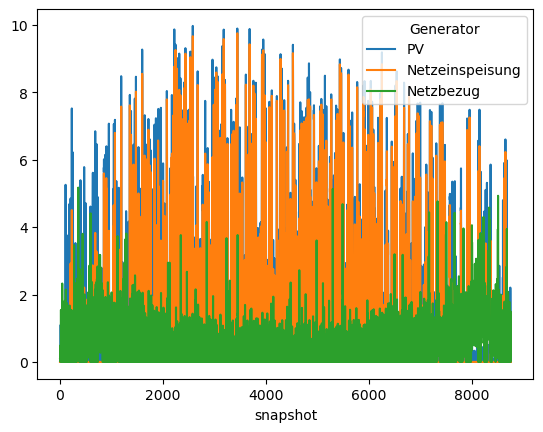

In [12]:
network.generators_t.p.plot()

<AxesSubplot:xlabel='snapshot'>

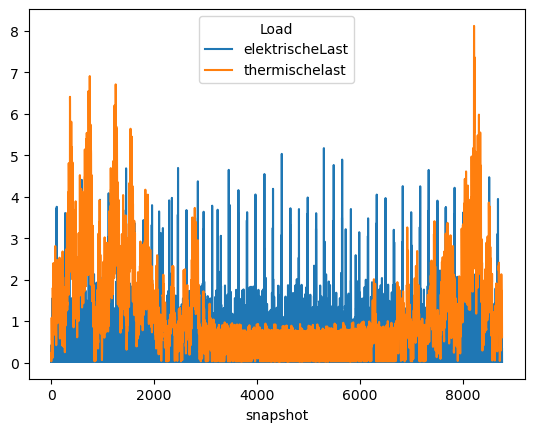

In [13]:
network.loads_t.p.plot()

In [14]:
network.generators_t.p.sum()

Generator
PV                 11581.694080
Netzeinspeisung     7817.730690
Netzbezug           3343.893649
dtype: float64

In [15]:
network.stores.e_nom_opt

Store
battriespeicher        0.030026
warmwasserspeicher    20.422789
Name: e_nom_opt, dtype: float64

array([<AxesSubplot:xlabel='snapshot'>, <AxesSubplot:xlabel='snapshot'>,
       <AxesSubplot:xlabel='snapshot'>], dtype=object)

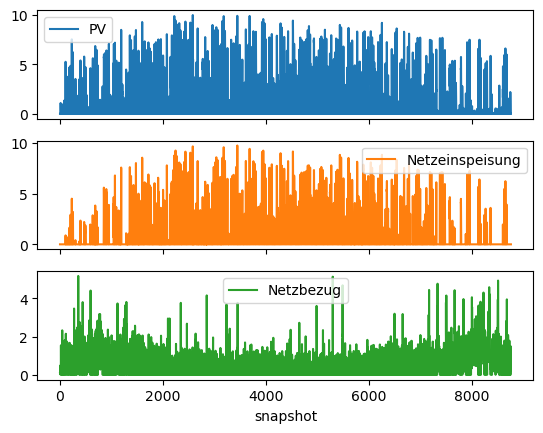

In [16]:
#Darstellung der Generatoren-Jahreslinie
network.generators_t.p.plot(subplots=True)

array([<AxesSubplot:xlabel='snapshot'>, <AxesSubplot:xlabel='snapshot'>],
      dtype=object)

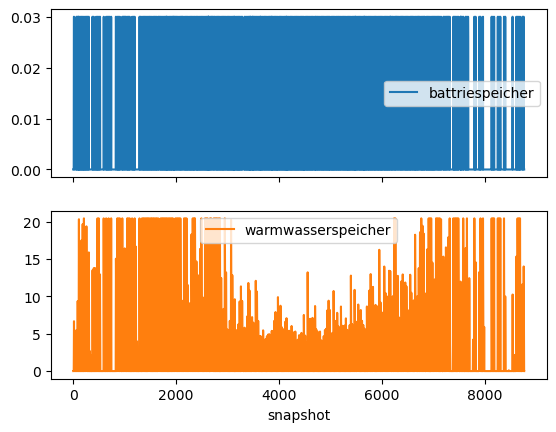

In [17]:
#Darstellung der Generatoren-Jahreslinie
network.stores_t.e.plot(subplots= True)

In [18]:
network.links.p_nom_opt.waermepumpe

3.0

In [19]:
#Definieren der zweiten Auswertungsfunktion (Wärmepumpe) ohne Sensitivitäsanaly

def auswertungsfunktion(network, sensitivity_variable = 0): 
    
    #Funktion der laufenden kosten
    
    #Funktion der laufende Kosten
    laufende_kosten_generators = (network.generators_t.p.Netzbezug * network.generators.marginal_cost.Netzbezug  +
                                       network.generators_t.p.PV * network.generators.marginal_cost.PV).sum()
    #Funktion für Investitionskosten
    kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()
    kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
    kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
    kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )
    
    #Gesamtkosten pro Jahr
    total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
    + kapital_kosten_stores + kapital_kosten_links) 
    
       
    #Einspeisevergütung (separat betrachtet von Gesamtkosten)
    einspeise_ertrag = (network.generators_t.p.Netzeinspeisung).sum()*strompreis_einspeisung *-1
    
    
    #Jährliche Einsparung der marginalen Kosten
    bezug_ursprung = (network.loads_t.p.elektrischeLast * network.generators.marginal_cost.Netzbezug + 
                      network.loads_t.p.thermischelast * gas_preis).sum()
    einsparung = bezug_ursprung - laufende_kosten_generators 
    
    #Armotisation
    Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) + (kapital_kosten_links *20)
    Amortisation = Anschaffungskosten/einsparung 
    
    
    #relevante Ausgabewerte
    netzbezug_summe = (network.generators_t.p.Netzbezug).sum()
    netzeinspeisung_summe= (network.generators_t.p.Netzeinspeisung).sum()
    pv_ertrag_summe = (network.generators_t.p.PV).sum()
    einspeicherung_summe = (network.links_t.p0.Einspeichern).sum()
    ausspeicherung_summe = (network.links_t.p0.Ausspeichern).sum()
    Kapazität_Batterie = (network.stores.e_nom_opt.battriespeicher)
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.warmwasserspeicher*36.85)
    Leistung_wp = (network.links.p_nom_opt.waermepumpe)
    
    
    
    #Werte in Ergebnistabelle auflisten
    results =pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                         pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                         pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                         pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                         pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                         pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                         pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                         pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                         pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                         pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                         pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                         pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                         pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität l']),
                         pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                         pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                         axis = 1)
    

               
    return results

In [20]:
result = auswertungsfunktion(network)
result

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität l,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
0,8294.147241,1564.111081,1337.557459,2901.668541,6956.589782,625.418455,94.067357,3343.893649,7817.73069,11581.69408,13.45845,9.791414,752.579767,0.030026,3.0


In [21]:
#Ausführung des Standardsnetzwerks
network.lopf(pyomo = False, solver_name = 'gurobi')
results = auswertungsfunktion(network, 1)                           


# Call up of the function results, clearing of the results DF
results.drop(results.index, inplace=True)  
results.index.name = 'Strompreis von 0,28 €/kWh bis 1,48 €kWh'


#Preisvariation und Ausgabe der neuen Ergebnisse
for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.1)): 
    print(strompreis_bezug)
    network.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 
    network.lopf(pyomo = False, solver_name = 'gurobi')
    results= results.append(auswertungsfunktion(network, strompreis_bezug )) 

network.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:2: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-sumljzk0.lp
Reading time = 0.60 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x19ce0db2
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.29s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


1.3799999999999997


INFO:pypsa.linopf:Total preparation time: 1.65s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-1n6we3yu.lp
Reading time = 0.59 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x725989e0
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.28s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 3.65e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


1.2799999999999998


INFO:pypsa.linopf:Total preparation time: 1.66s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-lnvv50rp.lp
Reading time = 0.60 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0xaaece2b4
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.29s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 3.42e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


1.1799999999999997


INFO:pypsa.linopf:Total preparation time: 1.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-sps_giqc.lp
Reading time = 0.66 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0xa2f99aeb
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.29s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 3.19e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


1.0799999999999998


INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-fgxaahyl.lp
Reading time = 0.53 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x0290864e
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.24s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.9799999999999999


INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-zb93yxbf.lp
Reading time = 0.54 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x47f02c98
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.24s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.8799999999999999


INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-us6up0ud.lp
Reading time = 0.51 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x0d0bca9e
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.23s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 2.48e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.7799999999999999


INFO:pypsa.linopf:Total preparation time: 1.71s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-o0k3opv2.lp
Reading time = 0.99 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x0dcf968c
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.36s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.6799999999999999


INFO:pypsa.linopf:Total preparation time: 1.36s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-nflh0yzj.lp
Reading time = 0.51 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0xf8232b91
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.24s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.58


INFO:pypsa.linopf:Total preparation time: 1.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-5fx95ifl.lp
Reading time = 0.51 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x4efb52fc
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.25s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.48


INFO:pypsa.linopf:Total preparation time: 1.72s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-ztl30whk.lp
Reading time = 0.57 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x7333299c
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.26s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.38


INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-bi8q2ica.lp
Reading time = 0.55 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x1d0da6c5
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.25s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 1.10e+03
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:15: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem


0.28


INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\pypsa-problem-j0r816qn.lp
Reading time = 0.54 seconds
obj: 210240 rows, 96368 columns, 385439 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 210240 rows, 96368 columns and 385439 nonzeros
Model fingerprint: 0x7382d8aa
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [3e+00, 3e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 157681 rows and 39470 columns
Presolve time: 0.26s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.569e+05 (roughly 50 MB of memory)
 Factor Ops : 8.838e+

INFO:pypsa.linopf:Optimization successful. Objective value: 7.59e+02
C:\Users\Lena\AppData\Local\Temp\ipykernel_3376\1775710485.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [22]:
#Ausgabe der Sensitivitätsanalyse des zweiten Netzwerks
results

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität l,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
1.38,10585.904360,2972.239343,3167.350670,6139.590013,7418.553689,435.806299,52.610526,2295.181645,5447.578738,11581.694082,1975.061730,1119.853128,1414.088042,5.833074,3.0
1.28,10359.954628,2853.028533,2956.161329,5809.189863,7403.793299,440.119431,54.705329,2309.501039,5501.492893,11581.694082,1937.192123,1105.271652,1389.385910,5.651274,3.0
1.18,10133.912943,2730.878714,2747.910998,5478.789712,7386.001945,445.855060,57.021953,2328.738134,5573.188251,11581.694082,1886.218071,1085.211354,1368.056530,5.423580,3.0
1.08,9906.468600,2605.742090,2542.647472,5148.389562,7363.821127,452.671447,59.590096,2354.303215,5658.393084,11581.694082,1819.772423,1057.922256,1345.588962,5.135529,3.0
0.98,9677.506405,2480.231098,2337.758314,4817.989412,7339.748090,460.469904,62.411508,2385.467668,5755.873796,11581.694082,1738.522144,1022.214989,1332.405647,4.811548,3.0
0.88,9446.978334,2348.597924,2138.991338,4487.589262,7307.986996,470.964666,65.639051,2430.671975,5887.058325,11581.694082,1636.383583,974.679690,1272.430463,4.427270,3.0
0.78,9216.047837,2206.783734,1950.405377,4157.189112,7265.642460,486.384493,69.473436,2500.519714,6079.806162,11581.694082,1490.771553,904.513472,1180.734317,3.926842,3.0
0.68,8979.093106,2069.622679,1757.166282,3826.788961,7221.926824,503.268671,73.655231,2584.068062,6290.858389,11581.694082,1321.563420,818.620994,1102.427379,3.393626,3.0
0.58,8741.115818,1916.895977,1579.492834,3496.388811,7161.622984,529.847358,78.894453,2723.263507,6623.091978,11581.694082,1064.896626,680.794487,985.789897,2.666812,3.0
0.48,8506.453962,1706.991644,1458.997016,3165.988661,7047.456946,581.791793,87.258271,3039.577118,7272.397409,11581.694082,502.558626,343.313695,842.517788,1.212206,3.0
